# Neural Image Caption Generator
##### I build a Deep Learning model using Keras, for genarating English caption text for any given image

#### Build a vocabulary of the most commonly occurring words in the caption text

In [3]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [4]:
print(type(content))

<class 'dict'>


In [5]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [6]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [7]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [8]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 2644


#### Prepare train and test data

In [ ]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/testImages.txt", 'r') as file:
    test_file_data = file.read()

In [ ]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [ ]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [ ]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

### Transfer Learning

#### Extract features from Image using a ResNet50 Architecture

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

Using TensorFlow backend.


102858752/102853048 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [ ]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


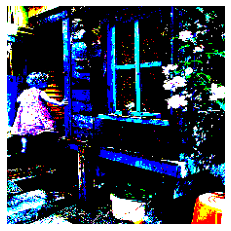

In [ ]:
import matplotlib.pyplot as plt

img = preprocess_image("data/Images/1000268201_693b08cb0e.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [ ]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Encoding in progress... STEP 1000
Encoding in progress... STEP 1100
Encoding in progress... STEP 1200
Encoding in progress... STEP 1300
Encoding in progress... STEP 1400
Encoding in progress... STEP 1500
Encoding in progress... STEP 1600
Encoding in progress... STEP 1700
Encoding in progress... STEP 1800
Encoding in progress... STEP 1900
Encoding in progress... STEP 2000
Encoding in progress... STEP 2100
Encoding in progress... STEP 2200
Encoding in progress... STEP 2300
Encoding in progress... STEP 2400
Encoding in progress... STEP 2500
Encoding in progress... STEP 2600
Encoding in progress... STEP 2700
Encoding in progress... STEP 2800
Encoding in progress... ST

In [ ]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [ ]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Total time taken: 19.501914739608765 s


In [ ]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

#### Pre-process the Captions

In [9]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [10]:
print(len(index_to_word))

2644


In [11]:
print(index_to_word[5])
print(word_to_index['is'])

is
5


In [12]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

In [13]:
print(VOCAB_SIZE)

2647


In [15]:
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [16]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [ ]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [ ]:
print(max_len)

38


In [ ]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("glove.6B.50d.txt",encoding='utf8')

In [ ]:
# Create a mapping from word to embedding
word_to_embedding = {}

for line in file:
    values = line.split()

    word = values[0]
    embedding = np.array (values[1:], dtype='float')
    word_to_embedding[word] = embedding

file.close()

In [ ]:
word_to_embedding["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
EMBEDDING_DIM = 50

def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding = word_to_embedding[word]

        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix

In [ ]:
index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)

(2647, 50)


### Define Model Architecture
##### Build a Neural Network using Keras Functional API

In [ ]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 essentially captures the entire sentence that has been generated till now

In [ ]:
from keras.layers.merge import add

# Decode the inputs

# So effectively, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 50)       132350      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Preinitialise Embedding layer
model.layers[2].set_weights([index_to_embedding])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

#### Create a Data Loader

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0     

### Train Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_content)//batch_size 

In [ ]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 192s 96ms/step - loss: 3.9762
Epoch 1/1
2000/2000 [==============================] - 192s 96ms/step - loss: 3.2665
Epoch 1/1
2000/2000 [==============================] - 193s 97ms/step - loss: 3.0100
Epoch 1/1
2000/2000 [==============================] - 206s 103ms/step - loss: 2.8537
Epoch 1/1
2000/2000 [==============================] - 209s 105ms/step - loss: 2.7408
Epoch 1/1
2000/2000 [==============================] - 208s 104ms/step - loss: 2.6578
Epoch 1/1
2000/2000 [==============================] - 205s 102ms/step - loss: 2.5906
Epoch 1/1
2000/2000 [==============================] - 195s 97ms/step - loss: 2.5347
Epoch 1/1
2000/2000 [==============================] - 193s 96ms/step - loss: 2.4883
Epoch 1/1
2000/2000 [==============================] - 193s 96ms/step - loss: 2.4506
Epoch 1/1
2000/2000 [==============================] - 195s 97ms/step - loss: 2.4191
Epoch 1/1
2000/2000 [==============================] - 190s 9